In [1]:
%load_ext autoreload
%autoreload 2

import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.io

from experiment import activation
from experiment import experiment
from experiment import michaels_load
from experiment import mRNN
from experiment import stim
from experiment import utils

import cpn_model

CUDA = None

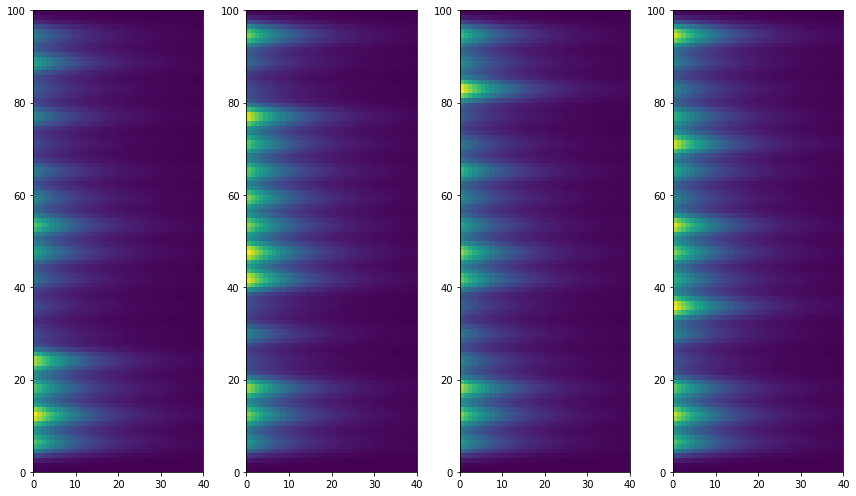

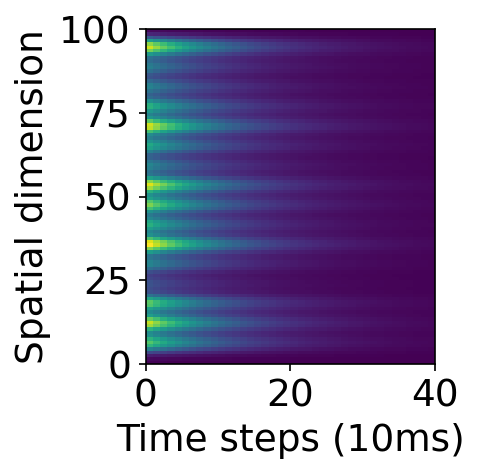

In [2]:
# Stimulation

num_stim_electrodes = 16
fig,axs = plt.subplots(1,4, figsize=(12,7))

stimulus = stim.StimulusGaussianExp(num_stim_electrodes, 100, sigma=1.875, batch_size=4, decay=0.09)
params = torch.tensor(np.array([random.uniform(0.5, 2.5) for _ in range(4 * num_stim_electrodes)]).reshape(
    4, -1)).float()
stimulus.add(params)

stims = [np.zeros((100, 40)) for _ in range(4)]
s = stimulus.get_next()
tidx = 0
while torch.sum(s) > 0.0 and tidx < 40:
    for bidx in range(4):
        stims[bidx][:, tidx] = s[bidx,:100]
    s = stimulus.get_next()
    tidx += 1

for bidx in range(4):
    axs[bidx].pcolormesh(stims[bidx][:,:])

fig.tight_layout()
plt.show()

plt.rc('font', size=18)
plt.figure(figsize=(3.5, 3.5), dpi=150)
plt.pcolormesh(stims[bidx][:, :])
plt.xlabel("Time steps (10ms)")
plt.ylabel("Spatial dimension")
plt.tight_layout()
plt.savefig('paper/figs/stim_single1.png', format='png', dpi=300)
plt.show()

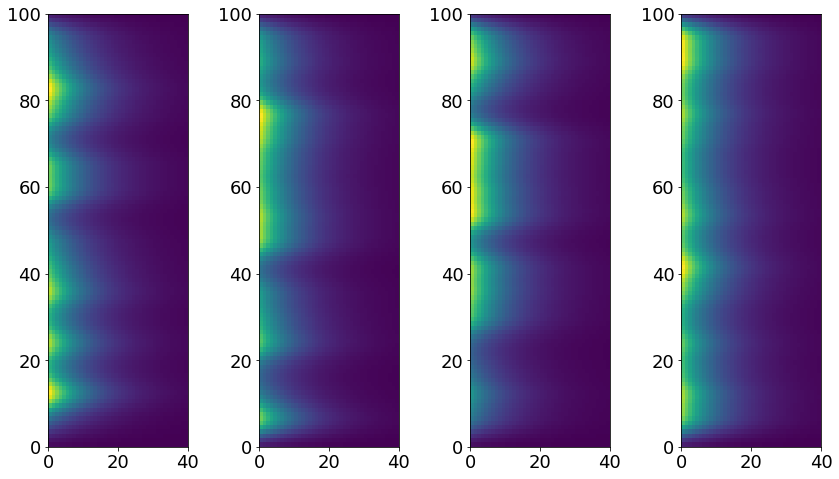

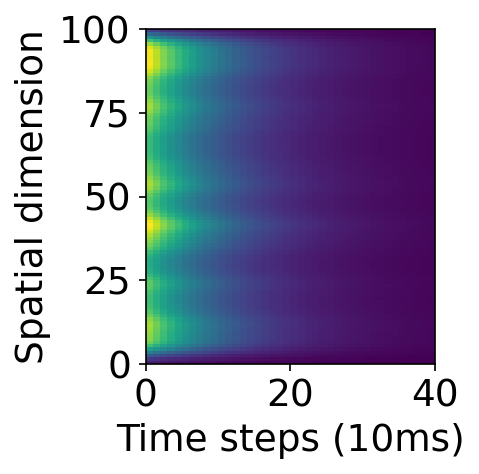

In [3]:
# Repeat prior experiment, with a higher sigma

num_stim_electrodes = 16
fig,axs = plt.subplots(1,4, figsize=(12,7))

stimulus = stim.StimulusGaussianExp(num_stim_electrodes, 100, sigma=2.875, batch_size=4, decay=0.09)
params = torch.tensor(np.array([random.uniform(0.5, 2.5) for _ in range(4 * num_stim_electrodes)]).reshape(
    4, -1)).float()
stimulus.add(params)

stims = [np.zeros((100, 40)) for _ in range(4)]
s = stimulus.get_next()
tidx = 0
while torch.sum(s) > 0.0 and tidx < 40:
    for bidx in range(4):
        stims[bidx][:, tidx] = s[bidx,:100]
    s = stimulus.get_next()
    tidx += 1

for bidx in range(4):
    axs[bidx].pcolormesh(stims[bidx][:,:])

fig.tight_layout()
plt.show()

plt.rc('font', size=18)
plt.figure(figsize=(3.5, 3.5), dpi=150)
plt.pcolormesh(stims[bidx][:, :])
plt.xlabel("Time steps (10ms)")
plt.ylabel("Spatial dimension")
plt.tight_layout()
plt.savefig('paper/figs/stim_single2.png', format='png', dpi=300)
plt.show()

In [3]:
# Load our models
# Our models are here
MODEL_BASE_PATH = os.path.join("models",
                               "gaussian20.1.75_outputsIdxs0.50_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt",
                               "b18b1962-9085-4042-872e-49d4761f1286"
                              )

cfg = experiment.get_m1_lesion_config(cuda=CUDA)

obs_dim, stim_dim, out_dim, cuda = cfg.unpack()
per_mod_obs_dim = cfg.observer_instance.out_dim


# Load models; skip EN since we aren't training
cpn = cpn_model.CPNModelLSTM(
    obs_dim,
    stim_dim,
    num_neurons=obs_dim,
    activation_func=cfg.cpn_activation,
    cuda=cuda,
)
cpn.load_state_dict(torch.load(os.path.join(MODEL_BASE_PATH, "cpn.model")))

mike = mRNN.MichaelsRNN(
    init_data_path=michaels_load.get_default_path(),
    stimulus=cfg.stim_instance,
    cuda=CUDA
)
mike.load_state_dict(torch.load(os.path.join(MODEL_BASE_PATH, "mike.model")))
mike.set_lesion(cfg.lesion_instance)

In [4]:
dataloader = cfg.loader_train
data = next(iter(dataloader))
batch_size, trial_len, out_dim = data[0].shape

stim_params = torch.zeros(batch_size, trial_len, stim_dim)
obs = torch.zeros(batch_size, trial_len, obs_dim - 1 + per_mod_obs_dim)
stims = torch.zeros(batch_size, trial_len, mike.num_neurons)
hidden = torch.zeros(batch_size, trial_len, mike.num_neurons)

din, trial_end, _, dout, labels = data

# First time step: no stimulation; just priming the mRNN
mike_in = din[:, 0, :].T
mike(mike_in)
hidden[:, 0, :] = mike.x

for tidx in range(1, trial_len):
    # Observe current activity
    obs_raw = mike.observe(cfg.observer_instance, drop_module_idx=0)
    obs[:, tidx - 1, per_mod_obs_dim:] = torch.cat(obs_raw, axis=1)
    
    brain_data = obs_raw + (trial_end[:, tidx - 1, :],)
    cpn_in = torch.cat(brain_data, axis=1)
    
    hidden[:, tidx, :] = mike.x
    stims[:, tidx, :] = mike.last_stimulus

    stim = cpn(cpn_in)
    stim_params[:, tidx - 1, :] = stim
    
    mike.stimulate(stim)

    mike_in = din[:, tidx, :].T
    mike(mike_in)

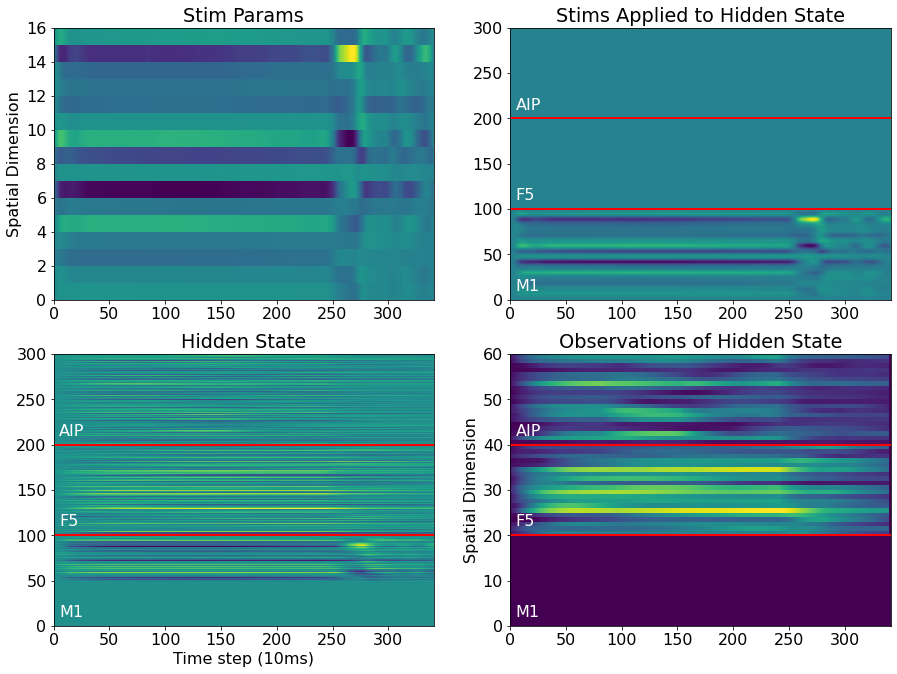

In [19]:
bidx = random.randrange(batch_size)

plt.rc('font', size=16)

fig,axs = plt.subplots(2,2, figsize=(15,11))

axs[0, 0].set_title("Stim Params")
axs[0, 0].pcolormesh(stim_params[bidx, :, :].cpu().detach().numpy().T)
axs[0, 0].set_ylabel("Spatial Dimension")

axs[0, 1].set_title("Stims Applied to Hidden State")
axs[0, 1].pcolormesh(stims[bidx, :, :].cpu().detach().numpy().T)
axs[0, 1].plot([0, trial_len], [mike.num_neurons_per_module, mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[0, 1].plot([0, trial_len], [2 * mike.num_neurons_per_module, 2 * mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[0, 1].text(5, 210, "AIP", color="w")
axs[0, 1].text(5, 110, "F5", color="w")
axs[0, 1].text(5, 10, "M1", color="w")

axs[1, 0].set_title("Hidden State")
axs[1, 0].pcolormesh(hidden[bidx, :, :].cpu().detach().numpy().T)
axs[1, 0].plot([0, trial_len], [mike.num_neurons_per_module, mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[1, 0].plot([0, trial_len], [2 * mike.num_neurons_per_module, 2 * mike.num_neurons_per_module], color='r', linestyle='-', linewidth=2)
axs[1, 0].text(5, 210, "AIP", color="w")
axs[1, 0].text(5, 110, "F5", color="w")
axs[1, 0].text(5, 10, "M1", color="w")
axs[1, 0].set_xlabel("Time step (10ms)")

axs[1, 1].set_title("Observations of Hidden State")
axs[1, 1].pcolormesh(obs[bidx, :, :].cpu().detach().numpy().T)
axs[1, 1].plot([0, trial_len], [per_mod_obs_dim, per_mod_obs_dim], color='r', linestyle='-', linewidth=2)
axs[1, 1].plot([0, trial_len], [2 * per_mod_obs_dim, 2 * per_mod_obs_dim], color='r', linestyle='-', linewidth=2)
axs[1, 1].text(5, 2 * per_mod_obs_dim + 2, "AIP", color="w")
axs[1, 1].text(5, per_mod_obs_dim + 2, "F5", color="w")
axs[1, 1].text(5, 2, "M1", color="w")
axs[1, 1].set_ylabel("Spatial Dimension")

plt.savefig('paper/figs/stim_and_obs.png', format='png', dpi=300)
plt.show()